In [1]:
import copy
import numpy as np
import albumentations as albu
import cv2
from matplotlib import pyplot as plt

class AlbumentationsAugmentor:
    def __init__(self, cfg, **kwargs):
        self.cfg = cfg

        self.albu = albu

        # Pixel-level transforms
        # Blur the input image using a random-sized kernel
        self.aug_blur = albu.Blur(blur_limit=3, always_apply=False, p=0.5)
        # Contrast Limited Adaptive Histogram Equalization
        self.aug_CLAHE = albu.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
        # Randomly Drop Channels in the input Image
        self.aug_ChannelDropout = albu.ChannelDropout(channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.5)
        # Randomly rearrange channels of the input RGB image
        self.aug_ChannelShuffle = albu.ChannelShuffle(always_apply=False, p=0.5)
        # CoarseDropout of the rectangular regions in the image
        self.aug_CoarseDropout = albu.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, fill_value=0, always_apply=False, p=0.5)
        # CoarseDropout of the square regions in the image
        self.aug_Cutout = albu.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5)

        # Apply gaussian noise to the input image
        self.aug_GaussNoise = albu.GaussNoise(var_limit=(10.0, 50.0), mean=None, always_apply=False, p=0.5)
        # Blur the input image using using a Gaussian filter with a random kernel size
        self.aug_GaussianBlur = albu.GaussianBlur(blur_limit=7, always_apply=False, p=0.5)
        # Randomly change hue, saturation and value of the input image
        self.aug_HueSaturationValue = albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.5)
        # Add gaussian noise to the input image
        self.aug_IAAAdditiveGaussianNoise = albu.IAAAdditiveGaussianNoise(loc=0, scale=(2.5500000000000003, 12.75), per_channel=False, always_apply=False, p=0.5)
        # Emboss the input image and overlays the result with the original image
        self.aug_IAAEmboss = albu.IAAEmboss(alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=0.5)
        # Sharpen the input image and overlays the result with the original image
        self.aug_IAASharpen = albu.IAASharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5)
        # superpixel representation. SLIC algorithm. May be slow
        self.aug_IAASuperpixels = albu.IAASuperpixels(p_replace=0.1, n_segments=100, always_apply=False, p=0.5)
        # Apply camera sensor noise
        self.aug_ISONoise = albu.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=0.5)
        # Invert the input image by subtracting pixel values from 255.
        self.aug_InvertImg = albu.InvertImg(always_apply=False, p=0.5)
        # Decrease Jpeg compression of an image
        self.aug_JpegCompression = albu.JpegCompression(quality_lower=99, quality_upper=100, always_apply=False, p=0.5)
        # Blur the input image using using a median filter with a random aperture linear size
        self.aug_MedianBlur = albu.MedianBlur(blur_limit=3, always_apply=False, p=0.5)
        # Apply motion blur to the input image using a random-sized kernel
        self.aug_MotionBlur = albu.MotionBlur(blur_limit=3, always_apply=False, p=0.5)
        # Divide pixel values by 255 = 2**8 - 1, subtract mean per channel and divide by std per channel
        self.aug_Normalize = albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0)
        # Randomly shift values for each channel of the input RGB image
        self.aug_RGBShift = albu.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5)
        # Random brightness
        self.aug_RandomBrightness = albu.RandomBrightness(limit=0.2, always_apply=False, p=0.5)
        # Randomly change brightness and contrast of the input image
        self.aug_RandomBrightnessContrast = albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, always_apply=False, p=0.5)
        # Random contrast
        self.aug_RandomContrast = albu.RandomContrast(limit=0.2, always_apply=False, p=0.5)
        # Simulates fog for the image
        self.aug_RandomFog = albu.RandomFog(fog_coef_lower=0.3, fog_coef_upper=1, alpha_coef=0.08, always_apply=False, p=0.5)
        # Random gamma
        self.aug_RandomGamma = albu.RandomGamma(gamma_limit=(80, 120), always_apply=False, p=0.5)
        # Adds rain effects
        self.aug_RandomRain = albu.RandomRain(slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1,
                                              drop_color=(200, 200, 200), blur_value=7, brightness_coefficient=0.7,
                                              rain_type=None, always_apply=False, p=0.5)
        # Simulates shadows for the image
        self.aug_RandomShadow = albu.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, always_apply=False, p=0.5)
        # Bleach out some pixel values simulating snow
        self.aug_RandomSnow = albu.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=2.5, always_apply=False, p=0.5)
        # Simulates Sun Flare for the image
        self.aug_RandomSunFlare = albu.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0, angle_upper=1,
                                        num_flare_circles_lower=6, num_flare_circles_upper=10, src_radius=400,
                                        src_color=(255, 255, 255), always_apply=False, p=0.5)
        # Invert all pixel values above a threshold
        self.aug_Solarize = albu.Solarize(threshold=128, always_apply=False, p=0.5)
        # Convert the input RGB image to grayscale. If the mean pixel value for the resulting image is greater than 127, invert the resulting grayscale image
        self.aug_ToGray = albu.ToGray(always_apply=False, p=0.5)
        # Take an input array where all values should lie in the range [0, 1.0], multiply them by max_value and then cast the resulted value to a type specified by dtype
        self.aug_FromFloat = albu.FromFloat(dtype='uint16', max_value=None, always_apply=False, p=1.0)
        # Divide pixel values by max_value to get a float32 output array where all values lie in the range [0, 1.0].
        self.aug_ = albu.ToFloat(max_value=None, always_apply=False, p=1.0)


        # Spatial-level transforms
        # Crop region from image
        self.aug_Crop = albu.Crop(x_min=0, y_min=0, x_max=1024, y_max=1024, always_apply=False, p=1.0)
        # Elastic deformation of images
        self.aug_ElasticTransform = albu.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, approximate=False, p=0.5)
        # # Flip the input either horizontally, vertically or both horizontally and vertically
        # self.aug_Flip = albu.Flip(always_apply=False, p=0.5)
        # Grid distortion
        self.aug_GridDistortion = albu.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
        # # Flip the input horizontally around the y-axis
        # self.aug_HorizontalFlip = albu.HorizontalFlip(always_apply=False, p=0.5)
        # affine transformations
        self.aug_IAAAffine = albu.IAAAffine(scale=1.0, translate_percent=None, translate_px=None, rotate=0.0,
                                            shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.5)
        # Crop and pad
        self.aug_IAACropAndPad = albu.IAACropAndPad(px=None, percent=None, pad_mode='constant', pad_cval=0, keep_size=True, always_apply=False, p=1)
        # Fliplr
        self.aug_IAAFliplr = albu.IAAFliplr(always_apply=False, p=0.5)
        # Flipud
        self.aug_IAAFlipud = albu.IAAFlipud(always_apply=False, p=0.5)
        # Perform a random four point perspective transform of the input
        self.aug_IAAPerspective = albu.IAAPerspective(scale=(0.05, 0.1), keep_size=True, always_apply=False, p=0.5)
        # Place a regular grid of points on the input and randomly move the neighbourhood of these point around via affine transformations
        self.aug_IAAPiecewiseAffine = albu.IAAPiecewiseAffine(scale=(0.03, 0.05), nb_rows=4, nb_cols=4, order=1, cval=0, mode='constant', always_apply=False, p=0.5)
        #
        self.aug_Lambda = albu.Lambda(image=None, mask=None, keypoint=None, bbox=None, name=None, always_apply=False, p=1.0)
        # Rescale an image so that maximum side is equal to max_size, keeping the aspect ratio of the initial image
        self.aug_LongestMaxSize = albu.LongestMaxSize(max_size=1024, interpolation=1, always_apply=False, p=1)
        #
        self.aug_NoOp = albu.NoOp(always_apply=False, p=0.5)
        #
        self.aug_OpticalDistortion = albu.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, interpolation=1,
                                                            border_mode=4, value=None, mask_value=None,
                                                            always_apply=False, p=0.5)
        # Pad side of the image / max if side is less than desired number
        self.aug_PadIfNeeded = albu.PadIfNeeded(min_height=1024, min_width=1024, border_mode=4, value=None, mask_value=None, always_apply=False, p=1.0)

        # Crop bbox from image with random shift by x,y coordinates
        self.aug_RandomCropNearBBox = albu.RandomCropNearBBox(max_part_shift=0.3, always_apply=False, p=1.0)
        # Random shuffle grid’s cells on image
        self.aug_RandomGridShuffle = albu.RandomGridShuffle(grid=(3, 3), always_apply=False, p=1.0)
        # Randomly rotate the input by 90 degrees zero or more times
        self.aug_RandomRotate90 = albu.RandomRotate90(always_apply=False, p=0.5)
        # Randomly resize the input. Output image size is different from the input image size
        self.aug_RandomScale = albu.RandomScale(scale_limit=0.1, interpolation=1, always_apply=False, p=0.5)
        # Rotate the input by an angle selected randomly from the uniform distribution
        self.aug_Rotate = albu.Rotate(limit=90, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
        # Randomly apply affine transforms: translate, scale and rotate the input
        self.aug_ShiftScaleRotate = albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, interpolation=1,
                                          border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
        # Rescale an image so that minimum side is equal to max_size, keeping the aspect ratio of the initial image
        self.aug_SmallestMaxSize = albu.SmallestMaxSize(max_size=1024, interpolation=1, always_apply=False, p=1)
        # Transpose the input by swapping rows and columns
        self.aug_Transpose = albu.Transpose(always_apply=False, p=0.5)
        # Flip the input vertically around the x-axis
        self.aug_VerticalFlip = albu.VerticalFlip(always_apply=False, p=0.5)

        # # Equalize the image histogram
        # self.aug_Equalize = albu.Equalize(mode='cv', by_channels=True, mask=None, mask_params=(), always_apply=False, p=0.5)
        # # Crop the central part of the input
        # self.aug_CenterCrop = albu.CenterCrop(height, width, always_apply=False, p=1.0)
        # # Crop a random part of the input
        # self.aug_RandomCrop = albu.RandomCrop(height, width, always_apply=False, p=1.0)
        # # Torchvision’s variant of crop a random part of the input and rescale it to some size
        # self.aug_RandomResizedCrop = albu.RandomResizedCrop(height, width, scale=(0.08, 1.0),
        #                                                     ratio=(0.75, 1.3333333333333333), interpolation=1,
        #                                                     always_apply=False, p=1.0)
        # # Crop a random part of the input and rescale it to some size without loss of bboxes
        # self.aug_RandomSizedBBoxSafeCrop = albu.RandomSizedBBoxSafeCrop(height, width, erosion_rate=0.0,
        #                                                                 interpolation=1, always_apply=False, p=1.0)
        # # Crop a random part of the input and rescale it to some size
        # self.aug_RandomSizedCrop = albu.RandomSizedCrop(min_max_height, height, width, w2h_ratio=1.0, interpolation=1,
        #                                                 always_apply=False, p=1.0)
        # # Resize the input to the given height and width
        # self.aug_Resize = albu.Resize(height, width, interpolation=1, always_apply=False, p=1)



        # all
        self.aug_all = self.albu.Compose([
            self.albu.OneOf([
                        self.aug_blur, self.aug_CLAHE, self.aug_ChannelDropout, self.aug_ChannelShuffle, self.aug_CoarseDropout,
                        self.aug_Cutout, self.aug_GaussNoise, self.aug_GaussianBlur, self.aug_HueSaturationValue, # self.aug_Equalize, self.aug_FromFloat, self.aug_ToFloat
                        self.aug_IAAAdditiveGaussianNoise, self.aug_IAAEmboss, self.aug_IAASharpen, self.aug_IAASuperpixels,
                        self.aug_ISONoise, self.aug_InvertImg, self.aug_JpegCompression, self.aug_MedianBlur,
                        self.aug_MotionBlur, self.aug_Normalize, self.aug_RGBShift, self.aug_RandomBrightness,
                        self.aug_RandomBrightnessContrast, self.aug_RandomContrast, self.aug_RandomFog,
                        self.aug_RandomGamma, self.aug_RandomRain, self.aug_RandomShadow, self.aug_RandomSnow,
                        self.aug_RandomSunFlare, self.aug_Solarize, self.aug_ToGray], p=0.5),
            self.albu.OneOf([
                        self.aug_Crop, self.aug_ElasticTransform, self.aug_GridDistortion,
                        self.aug_IAAAffine, self.aug_IAACropAndPad, self.aug_IAAFliplr, self.aug_IAAFlipud,
                        self.aug_IAAPerspective, self.aug_IAAPiecewiseAffine, self.aug_Lambda, self.aug_LongestMaxSize,
                        self.aug_NoOp, self.aug_OpticalDistortion, self.aug_PadIfNeeded,
                        #self.aug_Resize, self.aug_RandomSizedBBoxSafeCrop, self.aug_RandomSizedCrop, self.aug_RandomResizedCrop, self.aug_CenterCrop, self.aug_RandomCrop,
                        self.aug_RandomCropNearBBox, self.aug_RandomGridShuffle,
                        self.aug_RandomRotate90, self.aug_RandomScale,
                        self.aug_Rotate, self.aug_ShiftScaleRotate,
                        self.aug_SmallestMaxSize, self.aug_Transpose, self.aug_VerticalFlip], p=0.5)
                        ], p=0.8)
        
        
    def _example(self, **kwargs):
        """
        multi-task
        :param kwargs: {"image": image, "mask": mask, "bboxes":[[x1,y1,x2,y2],[x1,y1,x2,y2]], "category_id":[0,1], "keypoints":[[100,50],[75,200]]}
        :return: return what in kwargs
        """
        aug = kwargs.get("method_list", self.aug_all)
        return aug(**kwargs)


    def aug_image(self, image, **kwargs):
        """
        https://imgaug.readthedocs.io/en/latest/source/examples_basics.html
        :param image:
        :param kwargs:
        :return:
        """
        aug = kwargs.get("method_list", self.aug_all)
        out_image = aug(image=image)['image']
        return out_image


    def aug_image_and_bbox(self, image, dets, **kwargs):
        """
        https://imgaug.readthedocs.io/en/latest/source/examples_bounding_boxes.html
        dets: x1, y1, x2, y2, cls
        :param image:
        :param kwargs:
        :return:
        """
        aug = kwargs.get("method_list", self.aug_all)
        # bbox
        before_aug_boxes = []
        before_aug_label = []
        for det in dets:
            x1, y1, x2, y2, label = det
            before_aug_boxes.append([x1, y1, x2, y2])
            before_aug_label.append(label)

        annotations = aug(image=image, bboxes=before_aug_boxes, category_id=before_aug_label)
        out_image, bbs_aug, label_aug = annotations["image"], annotations["bboxes"], annotations["category_id"]
        out_dets = []
        for bb, ll in zip(bbs_aug, label_aug):
            x1, y1, x2, y2 = bb
            out_dets.append([x1, y1, x2, y2, ll])

        # if augmentataion failed
        if len(dets) != 0 and  len(out_dets) == 0:
            out_image = image.copy()
            out_dets = dets.copy()

        return out_image, out_dets


    def aug_image_and_mask(self, image, segmap, **kwargs):
        """
        https://imgaug.readthedocs.io/en/latest/source/examples_segmentation_maps.html
        nb_classes: [background_class_id] 1+ num_classes
        :param image: 
        :param segmap: 
        :param num_classes: 
        :param kwargs: 
        :return: 
        """
        aug = kwargs.get("method_list", self.aug_all)
        annotations = aug(image=image, mask=segmap)
        out_image, segmap_aug = annotations["image"], annotations["mask"]

        return out_image, segmap_aug


    def aug_image_and_keypoint(self, image, keypoints, **kwargs):
        """
        https://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html
        :param image: 
        :param keypoints: 
        :param kwargs: 
        :return: 
        """
        aug = kwargs.get("method_list", self.aug_all)
        aug = albu.Compose([aug], p=1, keypoint_params=albu.KeypointParams(format='xy'))
        # kps
        before_aug_keypoint = keypoints.copy()
        annotations = aug(image=image, keypoints=before_aug_keypoint)
        out_image, kps_aug = annotations["image"], annotations["keypoints"]

        out_kps = []
        for kp in kps_aug:
            x, y = kp
            if x >= 0 and x < image.shape[1] and y >= 0 and y < image.shape[0]:
                out_kps.append([x, y])
        # if augmentataion failed
        if len(keypoints) != 0 and len(out_kps) == 0:
            out_image = image.copy()
            out_kps = keypoints.copy()

        return out_image, out_kps
albuAugmentor = AlbumentationsAugmentor(None)

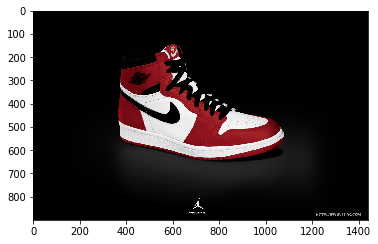

In [2]:
org_image = cv2.imread("../data/01.jpg")
plt.imshow(org_image[:,:,::-1])

image augmentation is done!


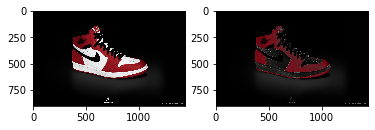

In [6]:
# image
aug_img = albuAugmentor.aug_image(org_image)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(org_image[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(aug_img[:,:,::-1])

print("image augmentation is done!")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


BB 0: (65.0000, 100.0000, 200.0000, 150.0000) -> (65.0000, 100.0000, 200.0000, 150.0000)
BB 1: (150.0000, 80.0000, 200.0000, 130.0000) -> (150.0000, 80.0000, 200.0000, 130.0000)
image and bounding boxes augmentation is done!


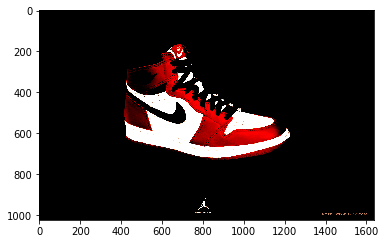

In [7]:
# bbox
dets = [[65, 100, 200, 150, 1], [150, 80, 200, 130, 0]]
aug_img, aug_dets = albuAugmentor.aug_image_and_bbox(org_image, dets)
plt.imshow(aug_img[:,:,::-1])
for i, (before, after) in enumerate(zip(dets, aug_dets)):
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (i,
                                                                           before[0], before[1], before[2],
                                                                           before[3],
                                                                           after[0], after[1], after[2],
                                                                           after[3]))
print("image and bounding boxes augmentation is done!")

image and segmentation maps(masks) augmentation is done!


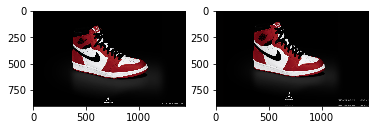

In [8]:
# mask
segmap = np.zeros((org_image.shape[0], org_image.shape[1]), dtype=np.int32)
segmap[56:142, 70:170] = 255
segmap[20:50, 60:90] = 150
segmap[20:50, 140:170] = 100
segmap[20:220, 10:20] = 180
segmap[236:246, 20:220] = 255

aug_img, aug_segmaps = albuAugmentor.aug_image_and_mask(org_image, segmap)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(org_image[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(aug_img[:,:,::-1])
print("image and segmentation maps(masks) augmentation is done!")


In [13]:
# keypoint
kps = [[65, 100], [75, 200], [100, 100], [200, 80]]
aug_img, aug_kps = albuAugmentor.aug_image_and_keypoint(org_image, kps)
for i, (before, after) in enumerate(zip(kps, aug_kps)):
    print("Keypoint %d: (%.8f, %.8f) -> (%.8f, %.8f)" % (
        i, before[0], before[1], after[0], after[1]))
print("image and keypoints augmentation is done!")


Keypoint 0: (65.00000000, 100.00000000) -> (65.00000000, 100.00000000)
Keypoint 1: (75.00000000, 200.00000000) -> (75.00000000, 200.00000000)
Keypoint 2: (100.00000000, 100.00000000) -> (100.00000000, 100.00000000)
Keypoint 3: (200.00000000, 80.00000000) -> (200.00000000, 80.00000000)
image and keypoints augmentation is done!
